In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import sys
import time
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
def getData(file):
	data = pd.read_csv(file, header=None)
	x = data.iloc[:,1:].to_numpy()
	y = data.iloc[:,0].to_numpy()
	y = np.array([int(i) for i in y])
	return x, y
 
def accuracy(y, pred):
	acc = 0
	for i in range(len(y)):
		if pred[i] == y[i]:
			acc += 1
	acc = acc/len(y)
	return acc

def ConfusionMatrix(y, pred, file):
	labels = np.unique(y)
	cm = confusion_matrix(y, pred)

	fig = plt.figure(figsize=(8,8))
	ax = fig.gca()
	_ = sns.heatmap(cm,annot=True,cmap="Blues",xticklabels=labels,yticklabels=labels,fmt='g')
	ax.set_xlabel("Actual Class")
	ax.set_ylabel("Predicted Class")
	plt.title("Confusion Matrix",y=1.08)
	ax.xaxis.tick_top()
	ax.xaxis.set_label_position('top')
	plt.savefig(file)
	plt.show()
	plt.close()

In [3]:
x_train, y_train = getData('/content/drive/MyDrive/Colab Notebooks/train.csv')
x_test, y_test = getData('/content/drive/MyDrive/Colab Notebooks/public_test.csv')
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(19376, 2304) (19376,)
(6459, 2304) (6459,)


In [4]:
tx_train = torch.FloatTensor(x_train.tolist()).cuda()
ty_train = torch.LongTensor(y_train.tolist()).cuda()
tx_test = torch.FloatTensor(x_test.tolist()).cuda()
ty_test = torch.LongTensor(y_test.tolist()).cuda()

print(tx_train.size())
print(ty_train.size())
print(tx_test.size())
print(ty_test.size())

torch.Size([19376, 2304])
torch.Size([19376])
torch.Size([6459, 2304])
torch.Size([6459])


In [5]:
class NeuralNet(nn.Module):
	def __init__(self, n, h, r):
		super(NeuralNet, self).__init__()
		self.l1 = nn.Linear(n, h)
		self.relu = nn.ReLU()
		self.l2 = nn.Linear(h, r)

	def forward(self, x):
		x = self.l1(x)
		x = self.relu(x)
		x = self.l2(x)
		return F.log_softmax(x, dim=1)

	def predict(self, x):
		num_batches = int(x.shape[0]/100)
		pred = np.array([0.])
		for i in range(num_batches):
			x_batch = x[i*100:(i+1)*100]
			pred = np.concatenate((pred, torch.max(self.forward(x_batch).data, 1)[1].cpu().numpy()))
		pred = np.concatenate((pred, torch.max(self.forward(x[num_batches*100:x.shape[0]]), 1)[1].cpu().numpy()))
		return pred[1:]

	def fit(self, x, y, r, optimizer, loss_func):
		num_batches = int(x.shape[0]/r)
		converged = False
		epochs = 0
		prevloss = 0
		error = 0
		while not converged:
			for i in range(num_batches):
				x_batch = x[i*r:(i+1)*r]
				y_batch = y[i*r:(i+1)*r]
				x_var = Variable(x_batch)
				y_var = Variable(y_batch)
				optimizer.zero_grad()
				out = self.forward(x_var)
				loss = loss_func(out, y_var)
				loss.backward()
				optimizer.step()
			error = abs(prevloss - loss.data)
			prevloss = loss.data
			print('Epoch: {} - Loss: {:.6f} - Error: {:.6f}'.format(epochs, loss.data, error))
			epochs += 1
			del loss
			if epochs > 10 and error < 1e-5 or epochs > 500:
				converged = True

In [6]:
model = NeuralNet(x_train.shape[1], 100, 7)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.CrossEntropyLoss()
print(model)

NeuralNet(
  (l1): Linear(in_features=2304, out_features=100, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=100, out_features=7, bias=True)
)


In [7]:
start = time.time()
model.fit(tx_train, ty_train, 100, optimizer, loss_func)
end = time.time()
print("Training Time = ", (end-start))

Epoch: 0 - Loss: 1.628434 - Error: 1.628434
Epoch: 1 - Loss: 1.595848 - Error: 0.032586
Epoch: 2 - Loss: 1.577543 - Error: 0.018305
Epoch: 3 - Loss: 1.592155 - Error: 0.014612
Epoch: 4 - Loss: 1.575853 - Error: 0.016302
Epoch: 5 - Loss: 1.542735 - Error: 0.033119
Epoch: 6 - Loss: 1.483951 - Error: 0.058783
Epoch: 7 - Loss: 1.454721 - Error: 0.029230
Epoch: 8 - Loss: 1.415840 - Error: 0.038881
Epoch: 9 - Loss: 1.362359 - Error: 0.053481
Epoch: 10 - Loss: 1.298778 - Error: 0.063581
Epoch: 11 - Loss: 1.254314 - Error: 0.044464
Epoch: 12 - Loss: 1.199122 - Error: 0.055191
Epoch: 13 - Loss: 1.139374 - Error: 0.059749
Epoch: 14 - Loss: 1.195099 - Error: 0.055725
Epoch: 15 - Loss: 1.142755 - Error: 0.052344
Epoch: 16 - Loss: 1.082108 - Error: 0.060647
Epoch: 17 - Loss: 1.059545 - Error: 0.022563
Epoch: 18 - Loss: 1.053322 - Error: 0.006223
Epoch: 19 - Loss: 1.027228 - Error: 0.026094
Epoch: 20 - Loss: 0.982566 - Error: 0.044663
Epoch: 21 - Loss: 0.957808 - Error: 0.024758
Epoch: 22 - Loss: 1.

Train Accuracy =  0.9920004128819158
Macro F1 Score  =  0.9922950068775912


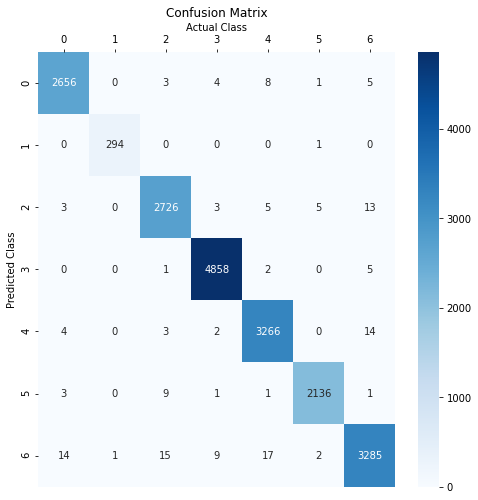

In [8]:
train_pred = model.predict(tx_train)
train_acc = accuracy(y_train, train_pred)
print("Train Accuracy = ", train_acc)
print("Macro F1 Score  = ", f1_score(y_train, train_pred, average='macro'))
ConfusionMatrix(y_train, train_pred, 'Q1atrain.png')

Test Accuracy =  0.40083604273107293
Macro F1 Score  =  0.3759643739796591


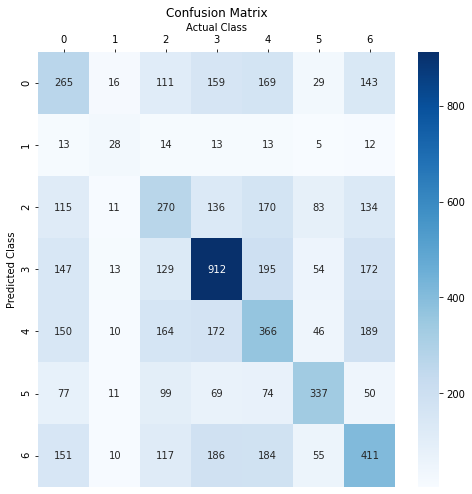

In [9]:
test_pred = model.predict(tx_test)
test_acc = accuracy(y_test, test_pred)
print("Test Accuracy = ", test_acc)
print("Macro F1 Score  = ", f1_score(y_test, test_pred, average='macro'))
ConfusionMatrix(y_test, test_pred, 'Q1atest.png')

In [10]:
! python3 '/content/drive/MyDrive/Colab Notebooks/Q1a.py' '/content/drive/MyDrive/Colab Notebooks/train.csv' '/content/drive/MyDrive/Colab Notebooks/private.csv' '/content/drive/MyDrive/Colab Notebooks/A4/Q1a.txt'

In [11]:
Q1a = torch.load('/content/drive/MyDrive/Colab Notebooks/A4/Q1a')

Train Accuracy =  0.9936519405450042
Macro F1 Score  =  0.9935079960086857


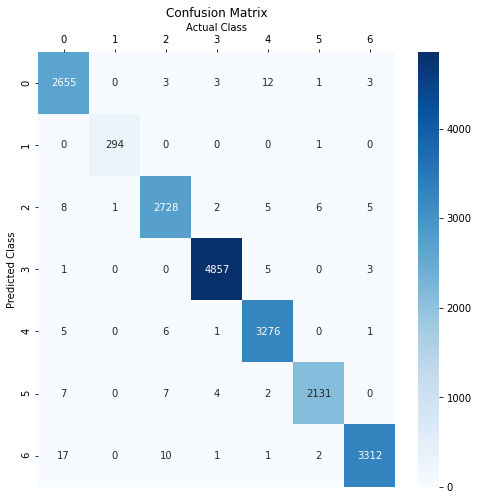

In [12]:
train_pred = Q1a.predict(tx_train)
train_acc = accuracy(y_train, train_pred)
print("Train Accuracy = ", train_acc)
print("Macro F1 Score  = ", f1_score(y_train, train_pred, average='macro'))
ConfusionMatrix(y_train, train_pred, 'Q1atrain.png')

Macro F1 Score  =  0.36715577101619373


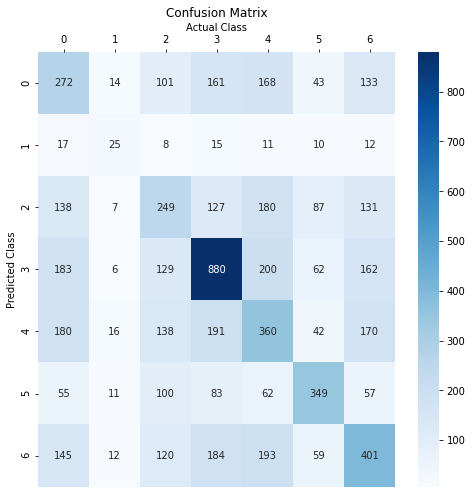

In [13]:
test_pred = Q1a.predict(tx_test)
test_acc = accuracy(y_test, test_pred)
print("Macro F1 Score  = ", f1_score(y_test, test_pred, average='macro'))
ConfusionMatrix(y_test, test_pred, 'Q1atest.png')